In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import random

# Фиксация зерна
SEED = 993
random.seed(SEED)
np.random.seed(SEED)

# 1. ЗАГРУЗКА (предполагается, что данные уже загружены выше в твоем скрипте)
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

# 2. FEATURE ENGINEERING (ОБНОВЛЕННЫЙ)
def create_smart_features(df, train_ref=None):
    # А) Глобальная статистика (если есть справочник)
    if train_ref is not None:
        prod_price_map = train_ref.groupby('product_id')['price_p05'].mean().to_dict()
        df['global_prod_avg'] = df['product_id'].map(prod_price_map)
        
        cat_price_map = train_ref.groupby('third_category_id')['price_p05'].mean().to_dict()
        df['global_cat_avg'] = df['third_category_id'].map(cat_price_map)
    
    # Б) Относительная представленность и масштаб
    cat_stores_map = df.groupby(['dt', 'third_category_id'])['n_stores'].transform('mean')
    df['store_density_ratio'] = df['n_stores'] / (cat_stores_map + 1e-6)
    
    # В) Продвинутая погода
    # Индекс теплового дискомфорта (комбинация темп. и влажности)
    df['heat_discomfort'] = df['avg_temperature'] + 0.55 * (1 - df['avg_humidity']/100) * (df['avg_temperature'] - 14.5)
    df['temp_hum_index'] = df['avg_temperature'] * (df['avg_humidity'] / 100)
    # Индекс суровости (ветер + осадки)
    df['weather_severity'] = df['avg_wind_level'] * df['precpt']
    
    # Г) Конкуренция и календарь
    df['category_breadth'] = df.groupby(['dt', 'third_category_id'])['product_id'].transform('nunique')
    
    # Расстояние до зарплаты (10 и 25 числа)
    df['is_salary_period'] = df['day_of_month'].apply(lambda x: 1 if x in [10, 11, 25, 26] else 0)
    
    # Д) Комбинированные категории (Interaction)
    df['cat_activity_mix'] = df['third_category_id'].astype(str) + "_" + df['activity_flag'].astype(str)
    
    return df

train = create_smart_features(train, train_ref=train)
test = create_smart_features(test, train_ref=train)

# 3. ЦИКЛИЧЕСКИЕ ПРИЗНАКИ
def add_cyclical_features(df):
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 4. СПИСОК ПРИЗНАКОВ (ОБНОВЛЕННЫЙ)
cat_features = [
    'management_group_id', 
    'first_category_id', 
    'activity_flag',
    'cat_activity_mix' # Новый комбинированный признак
]

features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year',
    'month_sin', 'month_cos',
    'global_prod_avg', 'global_cat_avg', 'store_density_ratio',
    'temp_hum_index', 'category_breadth',
    'heat_discomfort', 'weather_severity', 'is_salary_period' # Новые фичи
] + cat_features

# Заполняем NaN средними значениями из Train
train[features] = train[features].fillna(train[features].mean(numeric_only=True))
test[features] = test[features].fillna(train[features].mean(numeric_only=True))

# 5. ВАЛИДАЦИЯ (с фиксированным SEED)
train_parts, val_parts = [], []
for _, group in train.groupby('dt'):
    group = group.sample(frac=1, random_state=SEED).reset_index(drop=True)
    split_idx = int(len(group) * 0.8)
    train_parts.append(group.iloc[:split_idx])
    val_parts.append(group.iloc[split_idx:])

train_part = pd.concat(train_parts)
val_part = pd.concat(val_parts)

# Параметры CatBoost (random_seed зафиксирован)
cb_params = {
    'iterations': 2500,
    'learning_rate': 0.03,
    'depth': 7,
    'random_seed': SEED,
    'verbose': 100,
    'early_stopping_rounds': 200,
}

# Обучение на валидации
model_low = CatBoostRegressor(loss_function='MAE', **cb_params)
model_high = CatBoostRegressor(loss_function='MAE', **cb_params)

print("Обучение Low...")
model_low.fit(train_part[features], train_part['price_p05'], 
              eval_set=(val_part[features], val_part['price_p05']), 
              cat_features=cat_features, use_best_model=True)

print("Обучение High...")
model_high.fit(train_part[features], train_part['price_p95'], 
               eval_set=(val_part[features], val_part['price_p95']), 
               cat_features=cat_features, use_best_model=True)

# 6. ФИНАЛЬНОЕ ОБУЧЕНИЕ
print("Обучение финальных моделей на полном датасете...")

final_params_low = cb_params.copy()
final_params_low['iterations'] = model_low.get_best_iteration() + 1
final_params_low.pop('early_stopping_rounds', None)

final_params_high = cb_params.copy()
final_params_high['iterations'] = model_high.get_best_iteration() + 1
final_params_high.pop('early_stopping_rounds', None)

final_low = CatBoostRegressor(loss_function='MAE', allow_writing_files=False, **final_params_low)
final_high = CatBoostRegressor(loss_function='MAE', allow_writing_files=False, **final_params_high)

final_low.fit(train[features], train['price_p05'], cat_features=cat_features, verbose=100)
final_high.fit(train[features], train['price_p95'], cat_features=cat_features, verbose=100)

# 7. ПРЕДСКАЗАНИЕ
print("Создание предсказаний...")
test['price_p05'] = final_low.predict(test[features])
test['price_p95'] = final_high.predict(test[features])
test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission.csv', index=False)
print(f"Готово! Результаты зафиксированы с seed {SEED}.")

Обучение Low...
0:	learn: 0.1474781	test: 0.1411139	best: 0.1411139 (0)	total: 167ms	remaining: 6m 57s
100:	learn: 0.0908063	test: 0.0942197	best: 0.0942197 (100)	total: 2.79s	remaining: 1m 6s
200:	learn: 0.0878750	test: 0.0935452	best: 0.0935452 (200)	total: 5.33s	remaining: 1m
300:	learn: 0.0862076	test: 0.0932555	best: 0.0932555 (300)	total: 7.93s	remaining: 58s
400:	learn: 0.0846282	test: 0.0931077	best: 0.0931067 (396)	total: 10.4s	remaining: 54.6s
500:	learn: 0.0831946	test: 0.0931024	best: 0.0930592 (430)	total: 13s	remaining: 51.7s
600:	learn: 0.0819825	test: 0.0931394	best: 0.0930592 (430)	total: 15.5s	remaining: 49s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.09305915082
bestIteration = 430

Shrink model to first 431 iterations.
Обучение High...
0:	learn: 0.1003391	test: 0.0906935	best: 0.0906935 (0)	total: 25.3ms	remaining: 1m 3s
100:	learn: 0.0853858	test: 0.0885235	best: 0.0880555 (37)	total: 2.46s	remaining: 58.5s
200:	learn: 0.0825862	test: 0.089

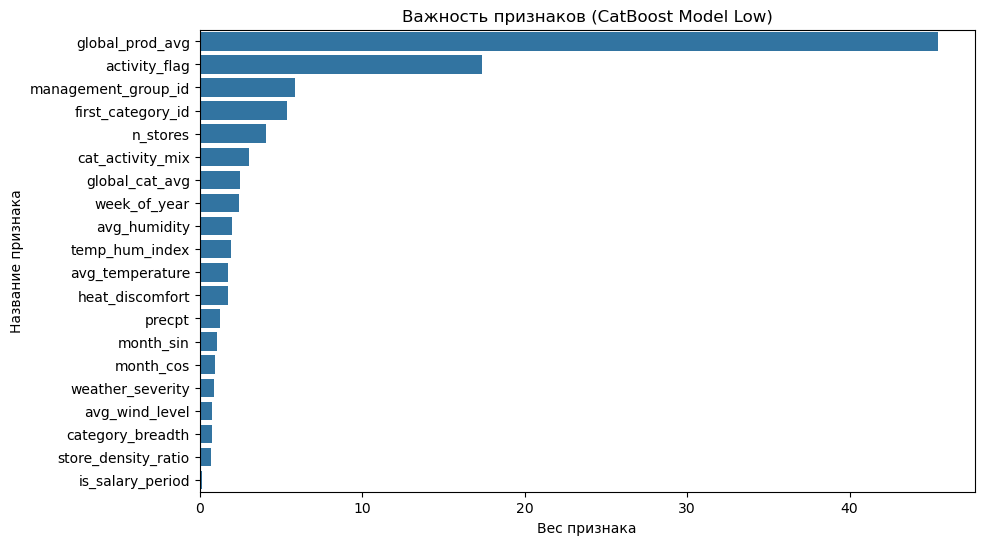

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()

In [7]:
feature_importance

,Feature Id,Importances
0,global_prod_avg,45.428414
1,activity_flag,17.398541
2,management_group_id,5.854789
3,first_category_id,5.399396
4,n_stores,4.086870
5,cat_activity_mix,3.007284
6,global_cat_avg,2.492824
7,week_of_year,2.394685
8,avg_humidity,1.973248
9,temp_hum_index,1.939928
